In [16]:
from occurrencerateclass import *
#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_moon
import estimate_PDF as pdf
import matplotlib.ticker
import linear_lnlike as llnl
%matplotlib inline

In [34]:
# get planet data
self = loadpickle('PipelineResults_TIC_sector5/TIC_results_0_10000_det')
g = self.disposition_human >= 0
#assert g.sum() == 21
print g.sum()

2


/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [35]:
# get ephemerides
g1 = np.in1d(self.disposition_human, [2,2.5])
g2 = np.in1d(self.disposition_human, [0,1])
Ps = np.append(self.Ps_singletransit[g1], self.Ps[g2])
ehiPs = np.append(self.ehi_Ps_singletransit[g1], self.e_Ps[g2])
eloPs = np.append(self.elo_Ps_singletransit[g1], self.e_Ps[g2])
T0s = np.append(self.T0s[g1], self.T0s[g2])
ehiT0s = np.append(self.e_T0s[g1], self.e_T0s[g2])
eloT0s = np.append(self.e_T0s[g1], self.e_T0s[g2])
ras = np.append(self.ras[g1], self.ras[g2])
decs = np.append(self.decs[g1], self.decs[g2])
tics = np.append(self.tics[g1], self.tics[g2])
dispositions_human = np.append(self.disposition_human[g1], self.disposition_human[g2])
#Ps = self.Ps[g]
#ehiPs = self.e_Ps[g]
#eloPs = self.e_Ps[g]
#T0s = self.T0s[g]
#ehiT0s = self.e_T0s[g]
#eloT0s = self.e_T0s[g]
#ras = self.ras[g]
#decs = self.decs[g]
#tics = self.tics[g]
#dispositions_human = self.disposition_human[g]

In [37]:
# define plotting functions
def plot_visibility(TIC, disposition, ra_deg, dec_deg, loc, UTCoffset, pltfolder='DragonflyPlots',
                    Ps=np.zeros(0), T0s=np.zeros(0), duration_days=6, saveplt=False):
    '''Plot the visibility (i.e. altitude or airmass) of a source from a fixed ground-based observatory.'''
    c = SkyCoord(ra_deg, dec_deg, frame='icrs', unit='deg')

    # define time array
    midnight = Time(date_mid) - UTCoffset
    delta_days = np.linspace(-duration_days/2., duration_days/2., 5000)*u.day
    times = midnight + delta_days
    frame = AltAz(obstime=times, location=loc)

    # get altitude vs time
    altazs = c.transform_to(frame)
    airmass = altazs.secz
    
    # get Sun's location
    sunaltazs = get_sun(times).transform_to(frame)

    # get Moon's location
    moonaltazs = get_moon(times).transform_to(frame)
    
    # plot airmass
    pltsecz = 0
    if pltsecz:
        plt.plot(delta_days, airmass)
        plt.ylim(1, 4)
        plt.xlabel('Delta Days')
        plt.ylabel('Airmass [Sec(z)]')
        
    # plot all sources
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    ax.plot(delta_days, sunaltazs.alt, color='r', label='Sun')
    ax.plot(delta_days, moonaltazs.alt, color=[0.75]*3, ls='--', label='Moon')
    img = ax.scatter(delta_days, altazs.alt, c=altazs.az, label='Target', lw=0, s=25, cmap=plt.get_cmap('viridis'))
    ax.fill_between(delta_days.to('day').value, 0, 90, sunaltazs.alt < -0*u.deg, color='0.5', zorder=0)
    ax.fill_between(delta_days.to('day').value, 0, 90, sunaltazs.alt < -18*u.deg, color='k', zorder=0)
    
    cbarax = fig.add_axes([.96, .1, .025, .8])
    cbar = fig.colorbar(img, cax=cbarax)
    cbar.set_label('Azimuth [deg]', fontsize=12)
    
    mn, mx = ax.set_ylim(0, 90)
    ax.set_xlim((delta_days.to('day').value.min(),delta_days.to('day').value.max()))
    ax.set_xlabel('Days since local midnight on %s'%date_str, fontsize=12)
    ax.set_ylabel('Altitude [deg]', fontsize=12)
    ax.set_title('TIC = %i, Disposition = %i\nRA = %.3f deg, Dec = %.3f deg'%(TIC,disposition,ra_deg,dec_deg), y=1.02)

    # plot planet transit posteriors
    if (len(Ps)==3) & (len(T0s)==3):
        P, ehiP, eloP = Ps
        T0, ehiT0, eloT0 = T0s
        y_edges, x_edges, Tmids = _compute_transit_times(P, ehiP, eloP, T0, ehiT0, eloT0, UTCoffset,
                                                         duration_days=duration_days)
        for i in range(y_edges.shape[0]):
            ax.plot(x_edges[i,1:]-np.diff(x_edges[i])[0]/2, y_edges[i]/y_edges[i].max()*80, 'w-')
            ax.axvline(Tmids[i], ls='--', lw=2, color='b')
            if i == 0:
                ax.fill_between(x_edges[i,1:]-np.diff(x_edges[i])[0]/2, np.zeros(y_edges[i].size), 
                                y_edges[i]/y_edges[i].max()*80, color='b', alpha=.4, label='Mid-transit time posterior')
            else:
                ax.fill_between(x_edges[i,1:]-np.diff(x_edges[i])[0]/2, np.zeros(y_edges[i].size), 
                                y_edges[i]/y_edges[i].max()*80, color='b', alpha=.5)
            
    # add airmass axis
    ax2 = ax.twinx()
    altitude_func = lambda X: 90 - np.rad2deg(np.arccos(1./X))
    ax2.set_ylim(0,90)
    airmasses = np.array([1,1.1,1.2,1.4,2,5])
    yticks = np.sort(altitude_func(airmasses))
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(airmasses[::-1])
    ax2.set_ylabel('Airmass', fontsize=12)
    for h in altitude_func(airmasses): ax2.axhline(h, color='grey', lw=.8)
        
    # add months for yearly plots
    #ax2 = ax.twinx()
    #xticks = np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31])
    #xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    #ax2.set_xticks(xticks)
    #ax2.set_xticklabels(xticklabels)
    fig.legend(loc='upper left')
    try:
        os.mkdir(pltfolder)
    except OSError:
        pass
    plt.savefig('%s/Dragonfly_visibility_TIC%i.png'%(pltfolder, TIC))
    plt.show()
        
        
def _compute_transit_times(P, ehiP, eloP, T0, ehiT0, eloT0, UTCoffset_obssite, 
                           duration_days=6.5, Nsamp=1e3, Nbins=30):
    '''Compute the transit probability over a range of dates available for transit follow-up and 
    return for plotting.'''
    # define time array
    midnight = Time(date_mid) - UTCoffset_obssite
    delta_days = np.linspace(-duration_days/2., duration_days/2., 5000)*u.day
    times = midnight + delta_days
    
    # compute transit probability
    _,_,samp_P = pdf.get_samples_from_percentiles(P, ehiP, eloP, Nsamp=int(Nsamp))
    _,_,samp_T0 = pdf.get_samples_from_percentiles(T0, ehiT0, eloT0, Nsamp=int(Nsamp))
    Norbits = int(np.round((midnight.jd - T0) / P)) - 1
    Ntransits_inwindow = int(np.ceil(duration_days / P)) + 1
    Nbins = int(Nbins)
    y_edges, x_edges = np.zeros((Ntransits_inwindow,Nbins)), np.zeros((Ntransits_inwindow,Nbins+1))
    Tmids = np.zeros(Ntransits_inwindow)
    for i in range(Ntransits_inwindow):
        Tmids[i] = T0 + (Norbits+i)*P
        print 'Most likely transit time = %.5f JD'%Tmids[i]
        samp_t = samp_T0 + (Norbits+i)*samp_P
        y_edges[i], x_edges[i] = np.histogram(samp_t, bins=Nbins)
    
    # return delta days
    x_edges -= midnight.jd
    Tmids -= midnight.jd
    return y_edges, x_edges, Tmids

In [38]:
# define observing location
lat = 32 + 54./60       # New mexico skies
lon = -105 + 32./60
elevation = 2635        # meters
UTCoffset = -6*u.hour   # New mexico
#lat = -24 - 36./60      # NGTS at Paranal
#lon = -70 - 23./60
#elevation = 2635        # meters
#UTCoffset = -4*u.hour   # New mexico
loc = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=elevation*u.m)
date_mid, date_str = '2019-3-20 00:00:00', 'Mar 20, 2019'

4.05158027958 4.05175829304 4.05193630651
2458442.43667 2458442.43711 2458442.43755
Most likely transit time = 2458559.93810 JD
Most likely transit time = 2458563.98986 JD
Most likely transit time = 2458568.04162 JD


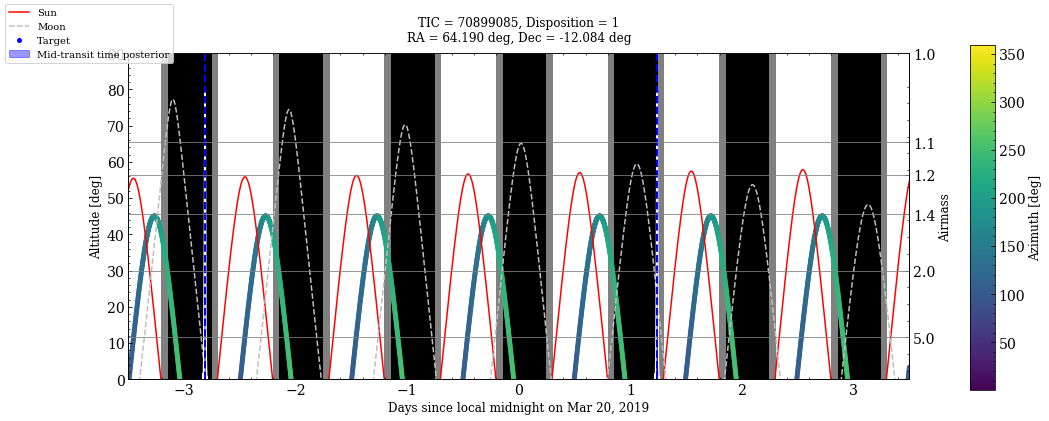

In [40]:
for i in range(1,tics.size):
    plot_visibility(tics[i], dispositions_human[i], ras[i], decs[i], loc, UTCoffset, Ps=[Ps[i],ehiPs[i],eloPs[i]], 
                    T0s=[T0s[i],ehiT0s[i],eloT0s[i]], duration_days=7, saveplt=True, 
                    pltfolder='DragonflyPlots/DragonflyPlots_sector5')

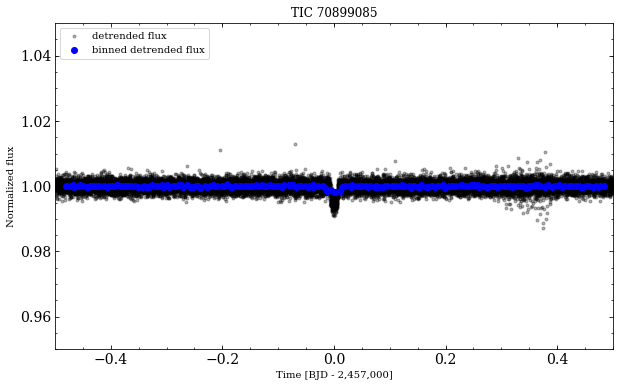

In [41]:
t0 = 2457000
d = loadpickle('PipelineResults_TIC_sector5/TIC_70899085/LC_-00099')
P,T0 = d.params_guess[0,:2]
phase = foldAt(d.bjd, P, T0)
phase[phase>.5] -= 1
tbin, fbin,_ = llnl.boxcar(phase, d.fcorr, d.ef, dt=.005)
plt.figure(figsize=(10,6))
plt.plot(phase, d.fcorr, 'k.', alpha=.3, label='detrended flux')
plt.plot(tbin, fbin, 'bo', label='binned detrended flux')
plt.xlim((-.5,.5)), plt.ylim((.95,1.05))
plt.xlabel('Time [BJD - 2,457,000]'), plt.ylabel('Normalized flux'), plt.title('TIC %i'%d.tic)
plt.legend(loc='upper left')
plt.savefig('DragonflyPlots/DragonflyPlots_sector6/TIC%i_ST_LC.png'%d.tic)

In [32]:
d.ra, d.dec

(103.1119, -22.3101)